# EE5907/EE5027 CA1
Author: Liu Weihao

Date: 20 Sep
### Part I: MAP
#### Q1,Q2,Q3

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
from matplotlib import cm
from matplotlib.ticker import LinearLocator

# beta = sigma^(-2)
SIGMA = 0.04
BETA = SIGMA ** (-2)

# Generate 50 2D-data points
x = np.arange(0,1,0.02)
y = np.sin(np.power(x,2) + 1)

# Add gaussian noise. 0-mean, standard deiation:sigma=0.2
noise = np.random.normal(0,SIGMA,size=(50))
y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q4: Fit the noisy data using the MAP
$$
\bar{W}=(\mathbb{X}^T\mathbb{X}+\frac{\alpha}{\beta}I)^{-1}\mathbb{X}^T\bar{t}
$$
Where $\bar{W}$ is what we want. $\mathbb{X}$ is a $N\times M$ matrix, $t$ is a $N\times 1$ matrix.
$$
\mathbb{X}=\left(\begin{array}{cc} 
x_0^0&x_0^1&\ldots&x_0^{M-1}\\
x_1^0&x_1^1&\ldots&x_1^{M-1}\\
\vdots & \vdots & \ddots & \vdots\\
x_{N-1}^0&x_{N-1}^1&\ldots&x_{N-1}^{M-1}
\end{array}\right)
$$
$$
\bar{t}=y=\left(\begin{array}{cc}
y_0\\y_1\\\vdots\\ y_{N-1}
\end{array}\right)
$$
In our case, $y$ is $t$. $\alpha$ is standard deiation of $w$, $\beta$ is standard deiation of $\bar{w}^T\bar{x}_n$($\bar{t}$).

In [ ]:
# Global parameter M and N. Let alpha = 0.05
LEN_M = 4
LEN_N = len(x)
ALPHA = 0.2
# Generate X and t
x_m = np.array([np.power(x,i) for i in range(LEN_M)]).reshape(LEN_M,LEN_N).T
t = y_noisy.reshape(LEN_N,1)
print(f'The shape of X is:{x_m.shape}\nThe shape of t is:{t.shape}')

In [ ]:
# Get W
tmp_w = np.linalg.inv((np.dot(x_m.T,x_m)+(ALPHA/BETA)*np.identity(LEN_M)))
w = np.dot(np.dot(tmp_w,x_m.T),t)
w.shape


#### Q5: Compute and display the total absolute error value (between the predicted and the correct ones) of using the computed w.

In [ ]:
# Get estimated values
y_est = np.dot(x_m,w)
# Calculate the absolute error value
abs_error = np.sum(np.abs(y.reshape(50,1)-y_est))
abs_error

#### Q6: Display the estimated values of w

In [ ]:
w

#### Q7
$M$ and $\alpha$ are hyper parameters. We can use hyperopt and tpe algorithm to find the best one. In this CA, we only need to try 5-10 different parameters.


##### Basic requirment. Try 10 different parameters.

In [ ]:
# define the MAP calculation function
def MAP_fitting(x:np.ndarray, y_noisy:np.ndarray, alpha:float, m:int)->np.ndarray:
    n = len(x)
    # Generate X and t
    mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
    t = y_noisy.reshape(n,1)
    # Calculate W
    tmp_w = np.linalg.inv((np.dot(mx.T,mx)+(alpha/BETA)*np.identity(m)))
    MAP_w = np.dot(np.dot(tmp_w,mx.T),t)
    # Return back the parameter w
    return MAP_w

# Calculate the absolute error
def MAP_error(w:np.ndarray, x:np.ndarray, y:np.ndarray) -> tuple[float, np.ndarray]:
    m = len(w)
    n = len(x)
    # Generate X
    mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
    # Estimate y
    y_est = np.dot(mx,w)
    # return the error
    return float(np.sum(np.abs(y.reshape(n,1)-y_est))), y_est

# x is our time series, y is the original data, y_noisy is the noisy data
def MAP_plt(x:np.ndarray, y:np.ndarray,y_noisy:np.ndarray, m_list:list, alpha_list:list):
    row_num = math.ceil(len(m_list)/3)
    col_num = 3
    fig, axs = plt.subplots(row_num,col_num, figsize=(15,9), constrained_layout=True)
    for ax, m, alpha in zip(axs.flatten(), m_list, alpha_list):
        # Calculate result
        MAP_w = MAP_fitting(x, y_noisy, alpha, m)
        error, y_est = MAP_error(MAP_w, x, y)
        ax.set_title(f'M={m}, alpha={alpha}, error={round(error,5)}')
        # plot function
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, y_est, 'b-')
    fig.suptitle('MAP fitting')

m_list= [1,2,3,\
         4,5,6,\
         10,10,10]
alpha_list = [0.01, 0.01, 0.01, \
              0.01, 0.01, 0.01, \
              0.05, 0.1, 0.5]
MAP_plt(x,y,y_noisy,m_list,alpha_list)


#### Q8 Discuss how M and alpha influence on the fitting accuracy.
Try 1000 different parameters, plot the 3D plot

In [ ]:
# Hyper parameter optimization. TPE algorithm
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
# The hyperparameter space
space = {
    'model_complexity': hp.quniform('model_complexity',3,20,1), # model_complexity is an integer. range: [3,20]
    'alpha': hp.uniform('alpha', 0.0001,20)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        mx = np.array([np.power(x,i) for i in range(m)]).reshape(m,n).T
        t = y_noisy.reshape(n,1)
        # Calculate W
        tmp_w = np.linalg.inv((np.dot(mx.T,mx)+(params['alpha']/BETA)*np.identity(m)))
        w = np.dot(np.dot(tmp_w,mx.T),t)
        # Calculate absolute error
        y_est = np.dot(mx,w)
        error = float(np.sum(np.abs(y.reshape(n,1)-y_est)))
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, alpha={}, error={}'.format(param['model_complexity'], round(param['alpha'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['alpha'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("alpha")
    ax.set_zlabel("absolute error")
    

# Try 1000 different parameters, find the best
hyper_opt(x, y, y_noisy,1000)

### Part II: Basis Function
#### Q1, Q2 Generate dataset (same as part I)

In [ ]:
# Use Part I dataset, so that we can compare MAP and MLE
# # beta = sigma^(-2)
# SIGMA = 0.2
# BETA = SIGMA ** (-2)

# # Generate 50 2D-data points
# x = np.arange(0,1,0.02)
# y = np.sin(np.power(x,2) + 1)

# # Add gaussian noise. 0-mean, standard deiation:sigma=0.15
# noise = np.random.normal(0,SIGMA**2,size=(50))
# y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q3: Fit the generated noisy data using the MLE that employs the Gaussian basis functions
$$
\bar{w}=(\Phi^T\Phi)^{-1}\Phi^T\bar{t}
$$
Where:$\Phi$ is a N by M matrix
$$
\Phi=\left(\begin{array}{cc} 
\phi_0(x_0)&\phi_1(x_0)&\ldots&\phi_{M-1}(x_0)\\
\phi_0(x_1)&\phi_1(x_1)&\ldots&\phi_{M-1}(x_1)\\
\vdots & \vdots & \ddots & \vdots \\
\phi_0(x_{N-1})&\phi_1(x_{N-1})&\ldots&\phi_{M-1}(x_{N-1})\\
\end{array}\right)
$$
Besides, We want to apply Gaussian basis function:
$$
\phi_m(x_n)=exp(-\frac{(x_n-\mu_m)^2}{2s^2})
$$
In my program, the mean $\mu_m$ is uniform distribution on $[0,1]$. $s=\frac{1}{M}$

In [ ]:
def gaussian_basis(x:np.ndarray, mu:float, s:float=1):
    return np.exp(- np.linalg.norm(x-mu)**2 / (2 * s**2))

def MLE_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((LEN_N, model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(gaussian_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(LEN_N,1)
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = MLE_basis(x, y_noisy, 4)
tmp_w

#### Q4: For underfitting, we use M=3. For overfitting, M=20

In [ ]:
# estimate the y
def basis_error(phi:np.ndarray, w:np.ndarray, y:np.ndarray) -> tuple[float, np.ndarray]:
    y_est = phi @ w
    # return the error
    return float(np.sum(np.abs(y.reshape(LEN_N,1)-y_est))), y_est

# Calculate the w
w_p2 = []
Phi = []
tmp_result = MLE_basis(x, y_noisy, 20)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])
tmp_result = MLE_basis(x, y_noisy, 3)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
for ax, tmp_w, tmp_phi in zip(axs.flatten(),w_p2, Phi):
    error, y_est = basis_error(tmp_phi, tmp_w, y)
    ax.set_title(f'M={len(tmp_w)}, error={round(error,5)}')
    ax.plot(x, y, 'r-')
    ax.scatter(x, y_noisy,color='green')
    ax.plot(x, y_est, 'b-')
fig.suptitle('Gaussian basis: overfitting and underfitting') 

#### Q5: Change the basis function to the sigmoid basis function
The sigmoid basis function can be expressed as:
$$
\phi_m(x_n)=\sigma(\frac{x_n-\mu_m}{s})=\frac{1}{1+exp(-\frac{x_n-\mu_m}{s})}
$$

In [ ]:
def sigmoid_basis(x:np.ndarray, mu:float, s:float=1):
    return 1 / (1 + np.exp(- np.linalg.norm(x-mu) / s))

def MLE_sigmoid_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((LEN_N, model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(sigmoid_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(LEN_N,1)
    w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = MLE_basis(x, y_noisy, 4)

# Calculate the w
w_p2 = []
Phi = []
tmp_result = MLE_sigmoid_basis(x, y_noisy, 20)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])
tmp_result = MLE_sigmoid_basis(x, y_noisy, 2)
w_p2.append(tmp_result[0])
Phi.append(tmp_result[1])

# Plot the result
fig, axs = plt.subplots(1,2, figsize=(8,4), constrained_layout=True)
for ax, tmp_w, tmp_phi in zip(axs.flatten(),w_p2, Phi):
    error, y_est = basis_error(tmp_phi, tmp_w, y)
    ax.set_title(f'M={len(tmp_w)}, error={round(error,5)}')
    ax.plot(x, y, 'r-')
    ax.scatter(x, y_noisy,color='green')
    ax.plot(x, y_est, 'b-')
fig.suptitle('Sigmoid basis: overfitting and underfitting')

#### Q6: Chang the original cureve function to $y=0.4345x^3-5.607x^2+16.78x-10.61$
Use the sigmoid function to estimate the best curve fitting from noisy data.
In my program. I use `hyperopt` to find the best parameter. $M$ and $s$ is the hyper parameter.

In [ ]:
# Generate new dataset
x_p2 = np.arange(0,10,0.2)
y_p2 = 0.4345*np.power(x_p2,3)-5.607*np.power(x_p2,2)+16.78*x_p2-10.61
# Gausion noise, sigma = 5
noise = np.random.normal(0,5,size=(50))
y_noisy_p2 = y_p2 + noise
plt.plot(x_p2,y_p2,'r-')
plt.scatter(x_p2,y_noisy_p2,color='green')
plt.show()

In [ ]:
# The hyperparameter space
space_p2 = {
        'model_complexity': hp.quniform('model_complexity',3,30,1), # model_complexity is an integer. range: [3,20]
        's': hp.uniform('s', 0.00001,200)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_p2_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        Phi = np.ones((n, m))
        sigma = params['s']
        # First column is 1. other column apply gaussian basis function
        for i in range(1,m):
            mu = 10*i/m
            Phi[:,i] = np.vectorize(sigmoid_basis)(x, mu, sigma)

        # Calculate W
        t = y_noisy.reshape(LEN_N,1)
        if np.linalg.det(Phi.T @ Phi) == 0:
            return {'loss':200, 'status':STATUS_OK, 'params':params, 'y_estimation':0}
        w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t

        # Calculate absolute error
        error, y_est = basis_error(Phi, w, y)
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt_p2(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_p2_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space_p2,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, s={}, error={}'.format(param['model_complexity'], round(param['s'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['s'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("s")
    ax.set_zlabel("absolute error")
    

# Try 3000 different parameters, find the best 3 results
hyper_opt_p2(x_p2, y_p2, y_noisy_p2,3000)

#### Q7: Experiment with different parameters of the Gaussian and sigmoid basis functions.
The sigmoid result is shown as above graph. Next, I will try to find the best model from Gaussian basis function.

In [ ]:
# The hyperparameter space
space_p2_gau = {
                'model_complexity': hp.quniform('model_complexity',3,30,1), # model_complexity is an integer. range: [3,20]
                's': hp.uniform('s', 0.00001,200)                       # alpha is a float number, range: [0.0001,10]
}

# Create a optimization function. Input our data
def get_p2_gau_objective(x:np.ndarray,y:np.ndarray, y_noisy:np.ndarray):
    # params is our hyper parameter
    def objective(params:dict):
        m = int(params['model_complexity'])
        n = len(x)
        # Data processing
        Phi = np.ones((n, m))
        sigma = params['s']
        # First column is 1. other column apply gaussian basis function
        for i in range(1,m):
            mu = 10*i/m
            Phi[:,i] = np.vectorize(gaussian_basis)(x, mu, sigma)

        # Calculate W
        t = y_noisy.reshape(LEN_N,1)
        # Drop the singular result
        if np.linalg.det(Phi.T @ Phi)==0:
            return {'loss':5000, 'status':STATUS_OK, 'params':params, 'y_estimation':0}
        w = np.linalg.inv(Phi.T @ Phi) @ Phi.T @ t
        # Calculate absolute error
        error, y_est = basis_error(Phi, w, y)
        # The upper bound of error is 5000
        error = 5000 if error > 5000 else error
        objective.i += 1
        return {'loss':error, 'status':STATUS_OK, 'params':params, 'y_estimation':y_est}
    return objective

# Call the hyperparameter optimization function, and deal with the resuls
# Plot best 3 results. Default try 100 parameters
def hyper_opt_gau_p2(x:np.ndarray, y:np.ndarray, y_noisy, num_trails:int=100):
    trails = Trials()
    objective = get_p2_gau_objective(x, y, y_noisy)
    objective.i = 0
    best = fmin(
        fn=objective,
        space = space_p2_gau,
        algo = tpe.suggest,
        max_evals = num_trails,
        trials= trails
    )
    # Get best 3 results
    hyper_opt_results = np.array(trails.trials)
    error_list = np.array([hyper_opt_results[i]['result']['loss'] for i in range(num_trails)])
    result_argsort = np.argsort(error_list)
    best_results = hyper_opt_results[result_argsort[0:3]]

    # plot the best 3 results
    fig, axs = plt.subplots(1,3, figsize=(12,4), constrained_layout=True)
    for ax, iter_trail in zip(axs.flatten(), best_results):
        param = iter_trail['result']['params']
        ax.set_title('M={}, s={}, error={}'.format(param['model_complexity'], round(param['s'],5), round(iter_trail['result']['loss'],5)))
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy,color='green')
        ax.plot(x, iter_trail['result']['y_estimation'], 'b-')
    fig.suptitle('hyper parameter optimization')

    # plot the 3D graph. We can see the influence of M and alpha
    fig = plt.figure(figsize =(14, 9))
    ax = plt.axes(projection ='3d')
    # Get all parameters and error
    model_complexity_list = np.array([hyper_opt_results[i]['result']['params']['model_complexity'] for i in range(num_trails)])
    param_alpha_list = np.array([hyper_opt_results[i]['result']['params']['s'] for i in range(num_trails)])
    # plot the surface
    surf = ax.plot_trisurf(model_complexity_list, param_alpha_list, error_list, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    ax.set_xlabel("model complexity")
    ax.set_ylabel("s")
    ax.set_zlabel("absolute error")
    return best_results[0]['result']['params']['model_complexity'], best_results[0]['result']['params']['s']
    

# Try 1000 different parameters, find the best 3 results
tmp_m= hyper_opt_gau_p2(x_p2, y_p2, y_noisy_p2,1000)

### Part III: Full Bayseian + Predictive distribution
#### Q1. Generate dataset.(Same as Part I, II)

In [ ]:
# Use Part I dataset, so that we can compare MAP and MLE
# # beta = sigma^(-2)
# SIGMA = 0.2
# BETA = SIGMA ** (-2)

# # Generate 50 2D-data points
# x = np.arange(0,1,0.02)
# y = np.sin(np.power(x,2) + 1)

# # Add gaussian noise. 0-mean, standard deiation:sigma=0.15
# noise = np.random.normal(0,SIGMA**2,size=(50))
# y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q2: Compute w based on the full Bayesian inference by using basis functions.
$$
\bar{w}_{full}=(\Phi^T\Phi+\frac{\alpha}{\beta}I)^{-1}\Phi^T\bar{t}
$$

In [ ]:
# Let's apply Gaussian basis function
def Full_basis(x:np.ndarray, y_noisy:np.ndarray, model_m:int, alpha:float=ALPHA) -> tuple[np.ndarray, np.ndarray]:
    # Create an empty matrix
    Phi = np.ones((len(x), model_m))
    sigma = 1/model_m
    # First column is 1. other column apply gaussian basis function
    for m in range(1,model_m):
        mu = m/model_m
        Phi[:,m] = np.vectorize(gaussian_basis)(x, mu, sigma)

    #Apply the above formular
    t = y_noisy.reshape(len(x),1)
    w = np.linalg.inv(Phi.T @ Phi + (alpha/BETA)*np.identity(model_m)) @ Phi.T @ t
    return w, Phi
tmp_w, tmp_Phi = Full_basis(x, y_noisy, 7,ALPHA)
tmp_w

In [ ]:
# Plot the result
error, y_est = basis_error(tmp_Phi, tmp_w, y)
plt.plot(x,y,'r-')
plt.plot(x,y_est,'b-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q3: Change alpha and beta.
$\alpha = \sigma_1^{-2}$ ,$\sigma_1$ is the standard deviation of w's distribution.

$\beta = \sigma_2^{-2}$ ,$\sigma_2$ is the standard deviation of noisy.
#### Q4: Show best fitting.
use $p(w|t)$ to indicate which result is best.
$$
p(w|t)=G(\bar{w};\bar{m}_N,\mathbb{S}_N)\\
$$
Where: 
$$
\mathbb{S}_N=(\alpha I+\Phi^T\beta I\Phi)^{-1}=(\alpha I+\beta\Phi^T\Phi)^{-1}\\
\bar{m}_N=\mathbb{S}_N(\Phi^T\beta I\Phi+\alpha I\Phi)=\mathbb{S}_N\beta\Phi^T\bar{t}
$$
Suppose $\bar{w}$ is a $D\times 1$ matrix
$$
G(\bar{w};\bar{m}_N,\mathbb{S}_N)=\frac{1}{(2\pi)^{D/2}}\frac{1}{\lvert\mathbb{S}_N\rvert ^{1/2}}exp\{-\frac{1}{2}(\bar{w}-\bar{m}_N)^T\mathbb{S}_N^{-1}(\bar{w}-\bar{m}_N)\}
$$


In [ ]:
# Calculate Gaussian probability
def p_w_t(w:np.ndarray, m:np.ndarray, s:np.ndarray):
    dim = len(w)
    para_1 = (2*math.pi)**(-dim/2)
    para_2 = np.power(np.linalg.det(s),-0.5)
    para_3 = np.exp(-0.5*(w-m).T @ np.linalg.inv(s) @ (w-m))
    return para_1*para_2*para_3

def plt_alpha_beta(alpha_list:list, beta_list:list, x:np.ndarray, y:np.ndarray,m=7):
    # Create some empty lists to record our results
    w_list = []
    phi_list = []
    y_est_list = []
    error_list = []
    y_noisy_list = []
    # Full Bayesian parameter
    prob_list = []
    for alpha, beta in zip(alpha_list, beta_list):
        # Calculate noise and y_noisy
        sigma = beta**(-0.5)
        noise = np.random.normal(0,sigma,size=(50))
        y_noisy = y+noise
        y_noisy_list.append(y_noisy)
        # Calculate w
        tmp_w, tmp_Phi = Full_basis(x, y_noisy, m,alpha)
        w_list.append(tmp_w)
        phi_list.append(tmp_Phi)
        # Calculate y estimation and absolut error
        tmp_error, tmp_y_est = basis_error(tmp_Phi, tmp_w, y)
        error_list.append(tmp_error)
        y_est_list.append(tmp_y_est)
        # Calculate Full Bayesian parameter
        tmp_S = np.linalg.inv(alpha*np.identity(m) + beta*tmp_Phi.T @ tmp_Phi)
        tmp_m = beta * tmp_S @ tmp_Phi.T @ y_noisy.reshape(len(x),1)
        tmp_prob = p_w_t(tmp_w, tmp_m, tmp_S)
        prob_list.append(tmp_prob)


    # Print the p(w|t)
    print(prob_list)
    # plot the result
    row_num = math.ceil(len(w_list)/3)
    col_num = 3
    fig, axs = plt.subplots(row_num,col_num, figsize=(15,9), constrained_layout=True)
    for ax, alpha, beta, y_est, error, y_noisy2, prob in zip(axs.flatten(), alpha_list, beta_list, y_est_list, error_list, y_noisy_list, prob_list):
        # Calculate result
        ax.set_title(f'alpha={alpha}, beta={beta}, error={round(error,5)}')
        # plot function
        ax.plot(x, y, 'r-')
        ax.scatter(x, y_noisy2,color='green')
        ax.plot(x, y_est, 'b-')
    fig.suptitle(f'Full Bayseian, M={m}')

    fig = plt.figure(figsize =(8, 5))
    ax = plt.axes()
    best_index = np.argmax(prob_list)
    ax.set_title(f'alpha={alpha_list[best_index]}, beta={beta_list[best_index]}, error={round(error_list[best_index],5)}')
    ax.plot(x, y, 'r-')
    ax.scatter(x, y_noisy_list[best_index],color='green')
    ax.plot(x, y_est_list[best_index], 'b-')
    fig.suptitle(f'Best Model - Apply p(w|t)')
    
# 2 rows. 
# Row 1: alpha = 0.2, beta: 200,400,600
# Row 2: alpha = 600, beta: 0.1, 0.3, 0.4
alpha_list_p3 = [0.2, 0.2, 0.2,
                 0.1, 0.3, 0.4]
beta_list_p3 = [200, 400, 600,
                600, 600, 600]

plt_alpha_beta(alpha_list_p3, beta_list_p3,x,y)    
        

#### Q5:Explain how useful $p(w|t)$ for the training and testing stages.

#### Q6: Generate dataset. Same as Part I, II

In [ ]:
# Use Part I dataset, so that we can compare MAP and MLE
# # beta = sigma^(-2)
# SIGMA = 0.2
# BETA = SIGMA ** (-2)

# # Generate 50 2D-data points
# x = np.arange(0,1,0.02)
# y = np.sin(np.power(x,2) + 1)

# # Add gaussian noise. 0-mean, standard deiation:sigma=0.15
# noise = np.random.normal(0,SIGMA**2,size=(50))
# y_noisy = y+noise
plt.plot(x,y,'r-')
plt.scatter(x,y_noisy,color='green')
plt.show()

#### Q7: Compute the predictive distribution of every input data sequentially, where each input data is taken randomly from the noise data.
Refer to PRML 3.3.2
$$
\begin{aligned}
p(t_*|\bar{t})
&=\int p(t_*,\bar{w}|\bar{t})d\bar{w}\\
&=\int p(t_*|\bar{w})p(\bar{w}|\bar{t})d\bar{w}
\end{aligned}\\
\begin{aligned}
\textcircled{1}: & p(t_*|\bar{w})=G(t_*;\bar{w}^T\bar{\phi}(x_*),\beta^{-1})\\
\textcircled{2}: & p(\bar{w}|\bar{t})=p(\bar{w}|\bar{t},\alpha,\beta)=G(\bar{w};\bar{m}_n,\mathbb{S}_n)\\

&where:\\
&\mathbb{S}_n^{-1}=\mathbb{S}_{n-1}^{-1}+\beta\phi(x_n)^T\phi(x_n)\\
&\bar{m}_n=\mathbb{S}_n^(\mathbb{S}_{n-1}^{-1}\bar{m}_{n-1}+\beta\phi^T\bar{t})\\
&\bar{m}_0=0\\
&\mathbb{S}_0^{-1}=\alpha I
\end{aligned}
$$
Combine these two Gaussian distribution, we can get:
$$
\begin{aligned}
&p(t_*|x_*,\bar{t},\alpha,\beta)=G(t_*|\bar{m}_*,s_*)\\
&\bar{m}_*=\bar{m}_N^T\bar{\phi}(x_*)\\
&s_*=\beta^{-1}+\bar{\phi}^T(x_*)\mathbb{S}_N\phi(x_*)
\end{aligned}
$$

In my program, I assume the original values of t are 0. After I input new data, all the parameter will be updated. First, I use hyperopt find the best M and alpha. The beta is a constant which used in PART I.
##### Hyper parameter optimization, find maxminm p(w|t), get the best M and $\alpha$ ($\alpha = s^{-2}$).

100%|██████████| 1000/1000 [00:20<00:00, 49.13trial/s, best loss: 0.23281182729512073]


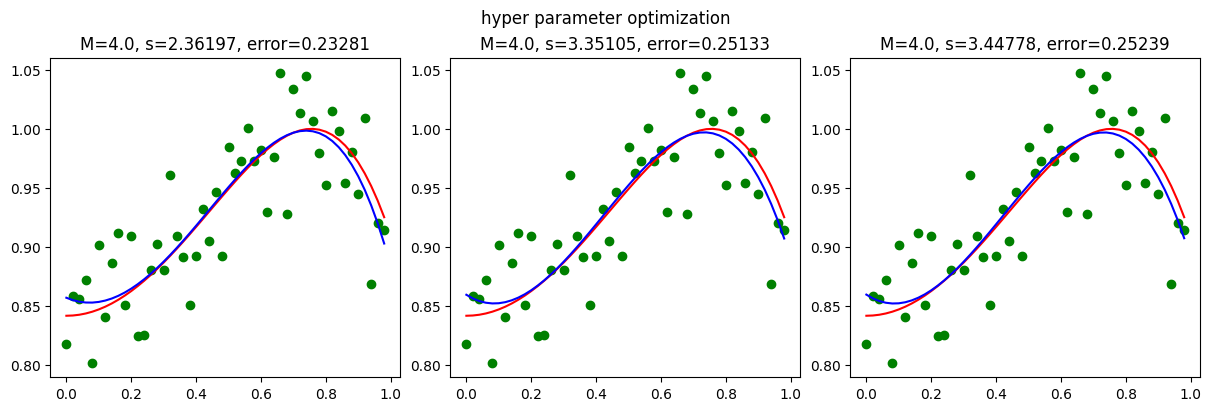

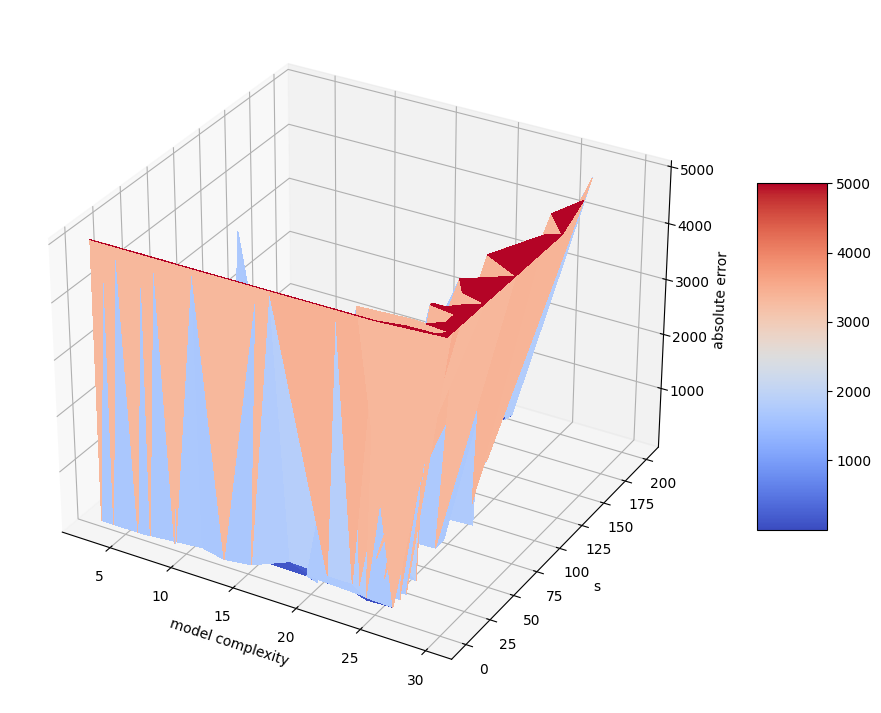

In [47]:
# Get the best model
m_p3, s_p3 = hyper_opt_gau_p2(x, y, y_noisy,1000)
alpha_p3 = s_p3 ** (-2)

Apply predictive distribution. 

In [92]:
# This function will colculate mean and standard deiation.
def get_s_m(x:np.ndarray, y:np.ndarray, m:int, alpha:float) -> tuple[np.ndarray,np.ndarray]:
    sigma_list = []
    mean_list = []
    m_0 = np.zeros((1,m))
    s_0 = alpha*np.identity(m)

    s_n_1 = s_0
    m_n_1 = m_0

    for x_in, y_in in zip(x,y):
        phi = np.ones((1,m))
        for i in range(1,m):
            mu = i / m
            phi[0,i] = np.exp(- alpha * (x_in-mu)**2 / 2)
        # Calculate s_n
        s_n = np.linalg.inv(np.linalg.inv(s_n_1)+BETA* phi.T @ phi)
        # Because m_0=0, python can not get the dot.
        if np.array_equal(m_0,m_n_1):
            m_n = BETA * s_n @ phi.T * y_in
        else:
            m_n = s_n @ (np.linalg.inv(s_n_1)@m_n_1 + BETA * phi.T * y_in)
        mean_list.append(m_n.T @ phi.T)
        sigma_list.append(BETA**(-1)+phi@s_n@phi.T)
        # Update s_{n-1} and m_{n-1}
        s_n_1 = s_n
        m_n_1 = m_n
    return np.array(mean_list).flatten(), np.array(sigma_list).flatten()

# The code of question 7. Generate a zero vector first.
def predictive_distribution(x:np.ndarray, y:np.ndarray, m:int, alpha:float):
    # Generate zero vector
    y_give = np.zeros(50)
    # Select y randomly
    



tmp_y = np.zeros(50)
tmp_y[25] = 0.021814885
tmp_mean, tmp_sigma = get_s_m(x, tmp_y, int(m_p3), alpha_p3)


0.17924673255450757

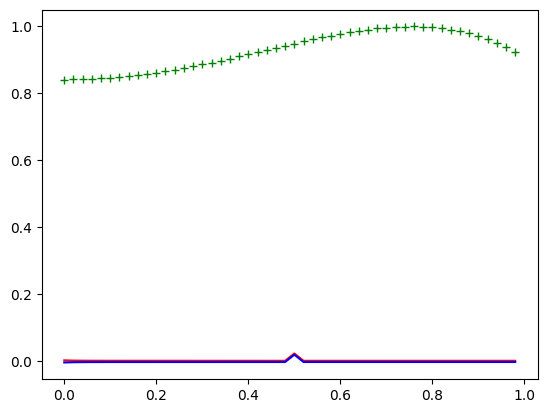

In [93]:
tmp_y_upper = tmp_y + tmp_sigma
tmp_y_low = tmp_y - tmp_sigma
plt.plot(x,tmp_y_upper,'r-')
plt.plot(x,tmp_y_low,'b-')
plt.plot(x,y,'g+')
# alpha_p3